In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyathena import connect
from pyathena.pandas.cursor import PandasCursor
from tensorflow.keras.models import load_model
from numpy.lib.stride_tricks import sliding_window_view

In [2]:
# Some constants - listed from the training, used to normalise the data

length = 48 # Length of the input and output vectors (samples)

start_date = '2022-04-18 12:00:00' 

days = 4
site_name = 'WITTERING'

sql = f"""
  select observation_ts, temperature, pressure, wind_speed, wind_direction
    from lake.weather 
    where site_name = '{site_name}' 
    and observation_ts >= parse_datetime('{start_date}', 'yyyy-MM-dd HH:mm:ss')
    and observation_ts < DATE_ADD('day', {days}, parse_datetime('{start_date}', 'yyyy-MM-dd HH:mm:ss'))
    order by observation_ts
"""

model_filename = 'data/weather_models/model2/'


In [3]:
# Grab some data
cursor = connect(s3_staging_dir="s3://dantelore.queryresults/pyathena/",
                 region_name="eu-west-1", cursor_class=PandasCursor).cursor()

df = cursor.execute(sql).as_pandas()

# Grab the last (length * 2) items from the results
df = df[-length * 2:-1].copy()

# Get rid if the nulls
df.fillna({'temperature': 0.0, 'pressure': 0.0}, inplace=True)

# Normalise temperature and pressure (values lifted from training notebook)
temperature_offset = 10.273621344002738
temperature_scale = 5.573310157238021
pressure_offset = 1013.9175258343165
pressure_scale = 12.165914294106491

df['temperature'] = df['temperature'].apply(lambda x: (x - temperature_offset) / temperature_scale)     
df['pressure'] = df['pressure'].apply(lambda x: (x - pressure_offset) / pressure_scale)     

# Time fields
def get_day_of_year_cos(dt):
    return -np.cos(dt.day_of_year / 365 * 2 * np.pi)

def get_hour_of_day_cos(dt):
    return -np.cos(dt.hour / 24 * 2 * np.pi)

df['observation_ts'] = pd.to_datetime(df['observation_ts'], infer_datetime_format=True)
df['hour_cos'] = df['observation_ts'].apply(get_day_of_year_cos)
df['day_of_year_cos'] = df['observation_ts'].apply(get_hour_of_day_cos)

# Wind fields
wind_lookup = {"N": 0.0,"NNE": 22.5,"NE": 45.0,"ENE": 67.5,"E": 90.0,"ESE": 112.5,"SE": 135.0,"SSE": 157.5,"S": 180.0,"SSW": 202.5,"SW": 225.0,"WSW": 247.5,"W": 270.0,"WNW": 292.5,"NW": 315.0,"NNW": 337.5,"": 0.0,None: 0.0}
wind_lookup = dict([(k, v * np.pi / 180.0) for k, v in wind_lookup.items()])

# Next convert to an X,Y coordinate, using direction and magnitude (wind speed)
def get_x(dir, magnitude):
    angle = wind_lookup[dir]
    return np.cos(angle) * magnitude

def get_y(dir, magnitude):
    angle = wind_lookup[dir]
    return np.sin(angle) * magnitude

df['wind_vector_x'] = df[['wind_direction', 'wind_speed']].apply(lambda v: get_x(*v), axis=1)
df['wind_vector_y'] = df[['wind_direction', 'wind_speed']].apply(lambda v: get_y(*v), axis=1)

# Grab the fields we need
fields = ['observation_ts', 'temperature', 'pressure', 'wind_vector_x', 'wind_vector_y', 'hour_cos', 'day_of_year_cos']
df = df[fields]

# Convert all the numbers to float32 for tensorflow
for col in fields[1:]:
    df[col] = df[col].astype('float32')

df

,observation_ts,temperature,pressure,wind_vector_x,wind_vector_y,hour_cos,day_of_year_cos
0,2022-04-18 12:00:00,0.614783,0.171173,-1.469576e-15,-8.000000,0.284359,1.000000e+00
1,2022-04-18 13:00:00,0.704497,0.171173,-1.836970e-15,-10.000000,0.284359,9.659258e-01
2,2022-04-18 14:00:00,0.812153,0.171173,-3.444151e+00,-8.314916,0.284359,8.660254e-01
3,2022-04-18 15:00:00,0.865981,0.088976,-2.388061e-15,-13.000000,0.284359,7.071068e-01
4,2022-04-18 16:00:00,0.794210,0.088976,-4.974885e+00,-12.010434,0.284359,5.000000e-01
...,...,...,...,...,...,...,...
90,2022-04-22 06:00:00,-0.336177,-0.322008,1.478207e+01,6.122935,0.349647,-6.123234e-17
91,2022-04-22 07:00:00,-0.210579,-0.322008,1.385819e+01,5.740252,0.349647,2.588190e-01
92,2022-04-22 08:00:00,0.022676,-0.322008,1.385819e+01,5.740252,0.349647,5.000000e-01
93,2022-04-22 09:00:00,0.291816,-0.322008,1.272792e+01,12.727922,0.349647,7.071068e-01


In [4]:
# Load the model
model = load_model(model_filename)

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-01-27 17:06:46.053609: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-27 17:06:46.053749: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
from datetime import datetime, timedelta

# Grab the first length-1 items
window = df[0:length-1]
window.set_index('observation_ts')

input_fields = fields[1:]

input = window[input_fields].to_numpy()

prediction_start = window['observation_ts'].max()
print(f"Prediction window starts at {prediction_start}")

results = []

for i in range(1, 48):
    prediction = model.predict(input.reshape((1, input.shape[0], input.shape[1])), verbose=0).flatten()

    next_timestep = prediction_start + pd.to_timedelta(i, unit='h')
    hour_cos = -np.cos(next_timestep.hour / 24 * 2 * np.pi)
    day_of_year_cos = -np.cos(next_timestep.day_of_year / 365 * 2 * np.pi)

    results.append([next_timestep] + prediction.tolist())

    new_input_row = np.append(prediction, [hour_cos, day_of_year_cos])

    input = input[1:]
    input = np.append(input, [new_input_row], axis=0)


results_df = pd.DataFrame(results, columns=['observation_ts', 'predicted_temperature', 'predicted_pressure', 'predicted_wind_vector_x', 'predicted_wind_vector_y'])
results_df.set_index('observation_ts')

results_df


Prediction window starts at 2022-04-20 10:00:00


2023-01-27 17:06:51.914843: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-27 17:06:52.193415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-27 17:06:52.285987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-27 17:06:52.402147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


,observation_ts,predicted_temperature,predicted_pressure,predicted_wind_vector_x,predicted_wind_vector_y
0,2022-04-20 11:00:00,-0.004675,1.102750,10.496605,5.823456
1,2022-04-20 12:00:00,0.064835,1.230654,11.624580,5.833883
2,2022-04-20 13:00:00,0.208710,1.361701,12.481675,5.719763
3,2022-04-20 14:00:00,0.397162,1.469319,13.090974,5.829985
4,2022-04-20 15:00:00,0.498045,1.528489,13.721387,5.640166
5,2022-04-20 16:00:00,0.631630,1.643948,13.942188,5.996160
6,2022-04-20 17:00:00,0.709976,1.762603,13.733299,6.296452
7,2022-04-20 18:00:00,0.677524,1.906967,12.796453,6.336819
8,2022-04-20 19:00:00,0.495059,2.027567,11.402166,5.938461
9,2022-04-20 20:00:00,0.278856,2.125969,10.262118,5.581123


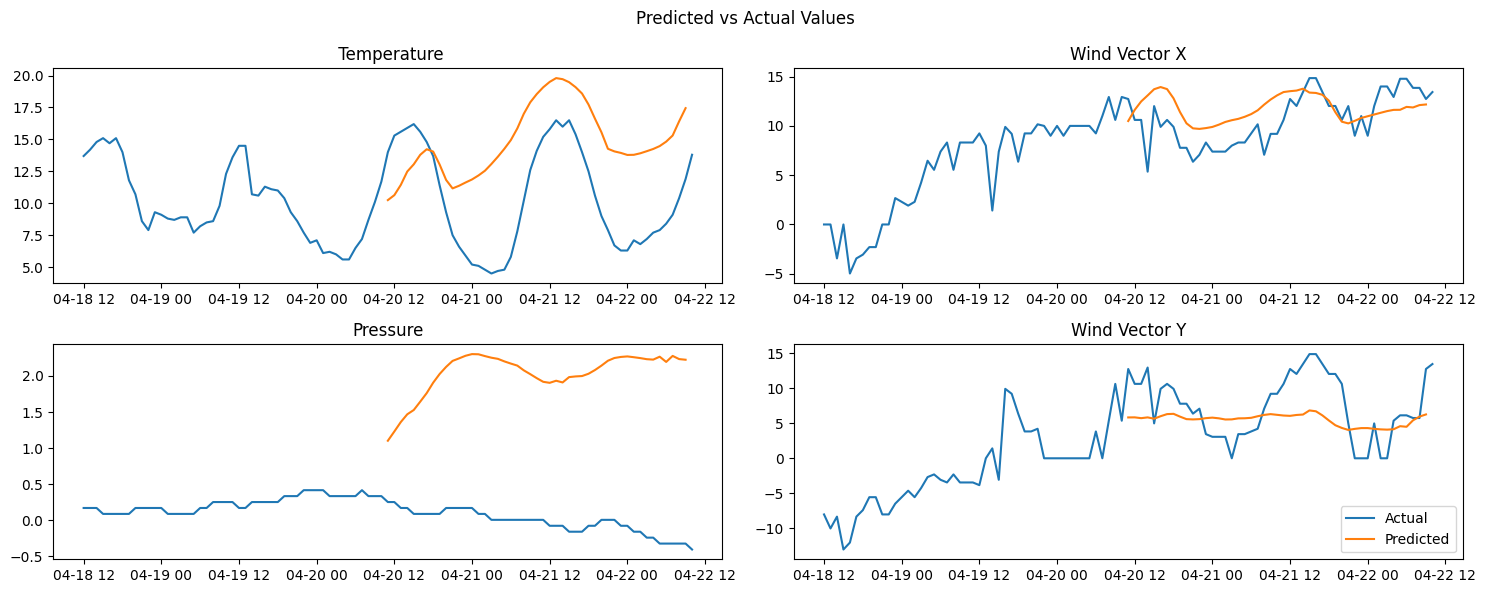

In [6]:
def denorm_temp(t):
    return t * temperature_scale + temperature_offset
    
def denorm_pressure(p):
    return p * pressure_scale + pressure_offset

fig, axs = plt.subplots(2, 2, figsize=(15, 6))
fig.suptitle('Predicted vs Actual Values')

axs[0,0].plot(df['observation_ts'], df['temperature'].map(denorm_temp))
axs[0,0].plot(results_df['observation_ts'], results_df['predicted_temperature'].map(denorm_temp))
axs[0,0].set_title(f' Temperature')

axs[1,0].plot(df['observation_ts'], df['pressure'].map(denorm_pressure))
axs[1,0].plot(results_df['observation_ts'], results_df['predicted_pressure'].map(denorm_pressure))
axs[1,0].set_title(f'Pressure')

axs[0,1].plot(df['observation_ts'], df['wind_vector_x'])
axs[0,1].plot(results_df['observation_ts'], results_df['predicted_wind_vector_x'])
axs[0,1].set_title(f'Wind Vector X')

axs[1,1].plot(df['observation_ts'], df['wind_vector_y'], label="Actual")
axs[1,1].plot(results_df['observation_ts'], results_df['predicted_wind_vector_y'], label="Predicted")
axs[1,1].set_title(f'Wind Vector Y')
axs[1,1].legend(loc="lower right")

fig.tight_layout()